In [951]:
# Import libraries
import pymc as pm
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import scipy as sp
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from arviz import plot_trace
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')

In [952]:
# Read the CSV file into a DataFrame. 
# Data is monthly, so we resample to quarterly, to obtain lagged values and later predict probabilities of S&P 500 within a predefined return range
df = pd.read_csv('resources/data.csv', usecols=['Date','S&P500','VIX','Interest Rates'], parse_dates=['Date'])
df = df.set_index('Date')
df = df.rename(columns={'S&P500': 'sp500', 'Interest Rates': 'interest_rates'})
df = df.resample('QS').last()
# Print the first few rows of the DataFrame
df.head()

,interest_rates,sp500,VIX
Date,,,
2000-01-01,5.85,1498.579956,24.110001
2000-04-01,6.53,1454.599976,19.540001
2000-07-01,6.52,1436.510010,20.570000
2000-10-01,6.40,1320.280029,26.850000
2001-01-01,5.31,1160.329956,28.639999


<Axes: title={'center': 'S&P 500 Returns'}, xlabel='Date'>

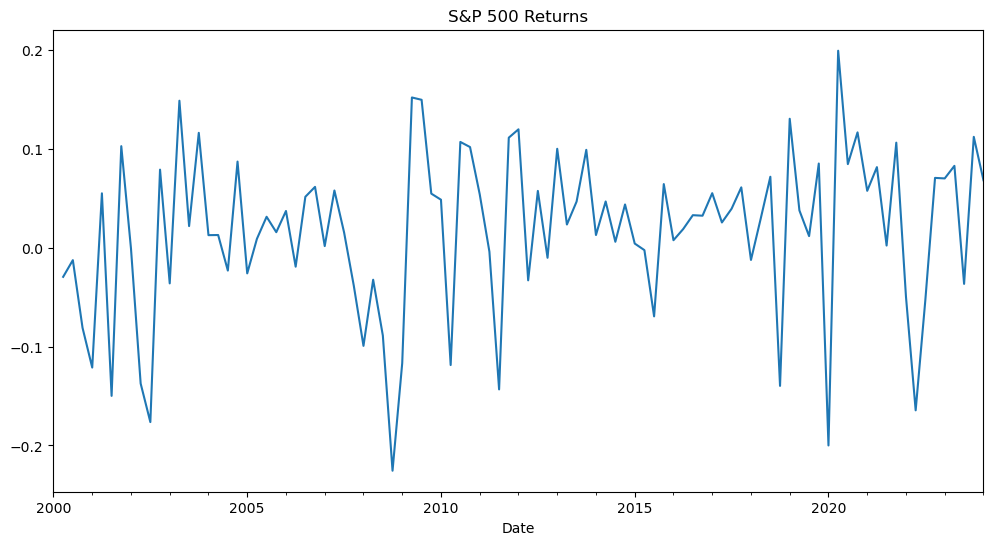

In [953]:
# Plot the S&P 500 quarterly returns
df['sp_returns'] = df['sp500'].pct_change()
df['sp_returns'].plot( title='S&P 500 Returns', figsize=(12, 6))

In [954]:
# Summary statistics of the S&P 500 returns
df['sp_returns'].describe()

count    96.000000
mean      0.016405
std       0.083609
min      -0.225582
25%      -0.023727
50%       0.027516
75%       0.070405
max       0.199529
Name: sp_returns, dtype: float64

Text(0.5, 1.0, 'S&P 500 Quarterly Returns')

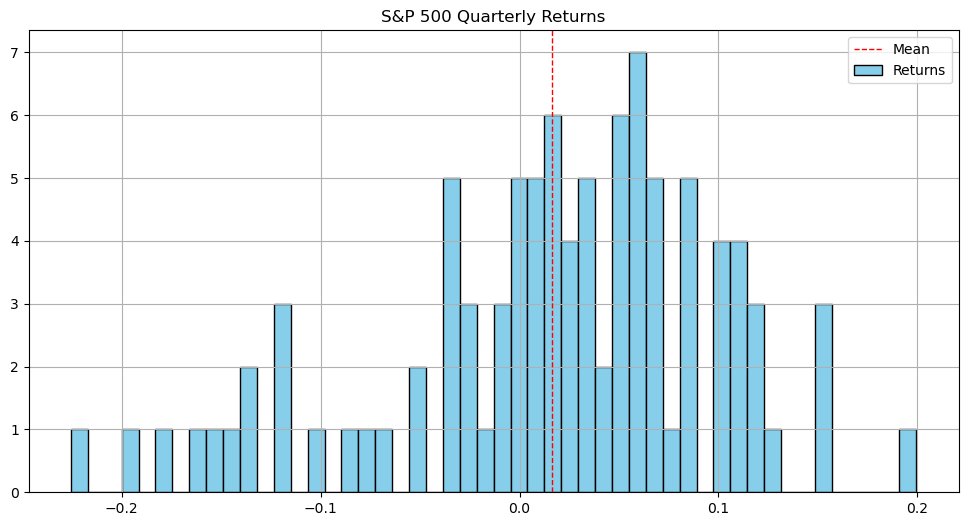

In [955]:
# Plot the histogram of the S&P 500 quarterly returns
df['sp_returns'].hist(bins=50, figsize=(12, 6), color='skyblue', edgecolor='black')
plt.axvline(df['sp_returns'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean', 'Returns'])
plt.title('S&P 500 Quarterly Returns')

In [956]:
# Summary of distributioon, kurtisis and skewness
# Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable.
# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
print('Skewness: ', (df['sp_returns']).skew())
print('Kurtosis: ', (df['sp_returns']).kurtosis())
print('Mean: ', (df['sp_returns']).mean())

Skewness:  -0.7326554094434153
Kurtosis:  0.44978824955341956
Mean:  0.016405181945510956


In [957]:
# Calculate Logarithmic Returns for S&P 500
df['sp_returns'] = np.log(df['sp500']).diff()
df['VIX_change'] = np.log(df['VIX']).diff()
df['interest_rates_change'] = np.log(df['interest_rates']).diff()
df = df.dropna()

In [958]:
# Create lagged features (adjust lag orders as needed)
df['sp_returns_lag1'] = df['sp_returns'].shift(1)
df['VIX_lag1'] = df['VIX_change'].shift(1)
df['interest_rates_lag1'] = df['interest_rates_change'].shift(1)
df = df.dropna()

In [959]:
# Select features. Experiment with feature engineering.
features = ['VIX_lag1', 'interest_rates_lag1', 'sp_returns_lag1']

In [960]:
# Time-based train/test split (using data up to 2021 for training)
train_end_year = 2022
train_data = df.loc[df.index.year <= train_end_year]
test_data = df.loc[df.index.year > train_end_year]

X_train = train_data[features].dropna()
y_train = train_data['sp_returns'] 

X_test = test_data[features].dropna()
y_test = test_data['sp_returns'] 

# Standardize features using RobustScaler because of potential outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [964]:
# Define the model for Bayesian Linear Regression for the prior predictive checks
with pm.Model() as model:
    # Tighten the priors to reduce the impact of outliers
    alpha = pm.Normal('alpha', mu=0, sigma=0.03)  # A tighter sigma to reduce impact of outliers
    beta_vix = pm.Normal('beta_vix', mu=0, sigma=0.01)  # Assuming more certainty about VIX impact
    beta_rates = pm.Normal('beta_rates', mu=0, sigma=0.01)  # Assuming more certainty about interest rates impact
    beta_sp = pm.Normal('beta_sp', mu=0, sigma=0.01)  # Assuming more certainty about lagged S&P 500 returns impact
    nu = pm.Exponential('nu', lam=1/20)  # Keeping broad to allow flexibility for fat tails
    sigma = pm.HalfNormal('sigma', sigma=0.03)  # A tighter sigma to reduce impact of outliers

    # Create a shared variable for your input data, making it mutable for updates
    X_shared = pm.MutableData('X_shared', X_train_scaled)
    y_shared = pm.MutableData('y_shared', y_train)  # Make y_train mutable

    # Define the likelihood function for the observed data
    sp_returns = pm.StudentT('sp_returns',
                              nu=nu,
                              mu=alpha + beta_vix * X_shared[:, 0] + beta_rates * X_shared[:, 1] + beta_sp * X_shared[:, 2],
                              sigma=sigma,
                              observed=y_shared)

In [965]:
# Prior predictive checks
with model:
    prior_checks = pm.sample_prior_predictive(samples=1000)

Sampling: [alpha, beta_rates, beta_sp, beta_vix, nu, sigma, sp_returns]


<xarray.DataArray 'sp_returns' ()>
array(20.) <xarray.DataArray 'sp_returns' ()>
array(-22.56)


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\xarray\core\computation.py:822: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


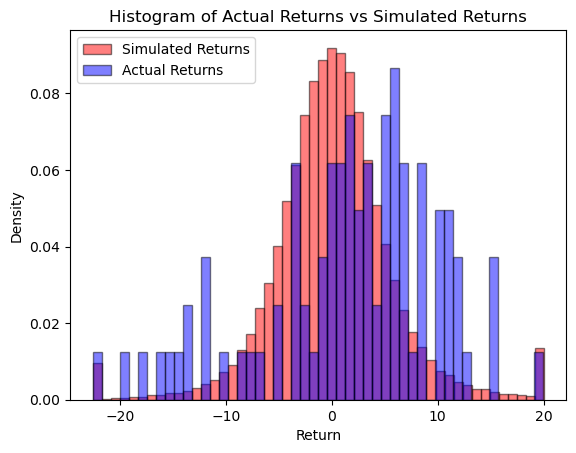

In [966]:
# Convert actual log returns to percentage returns
actual_returns = (np.exp(df['sp_returns']) - 1) * 100

# Get the log returns from the prior predictive checks
log_returns = prior_checks['prior_predictive']['sp_returns']

# Convert the log returns to percentage returns
percentage_returns = (np.exp(log_returns) - 1) * 100

# Define upper and lower limits based on described stats
upper_limit = 20  # 20 max value from described stats
lower_limit = -22.56 #-22.56 min value from described stats

# Clip the values to the upper and lower limits to limit the range of the outliers
clipped_percentage_returns = percentage_returns.clip(min=lower_limit, max=upper_limit)

# Check the max and min values again
print(clipped_percentage_returns.max(), clipped_percentage_returns.min())

# Plot the histogram of the percentage returns
plt.hist(clipped_percentage_returns.values.flatten(), bins=50, alpha=0.5, label='Simulated Returns', color='red', edgecolor='black', density=True)

# Plot the histogram of the actual returns
plt.hist(actual_returns, bins=50, alpha=0.5, label='Actual Returns', color='blue', edgecolor='black', density=True)

plt.title('Histogram of Actual Returns vs Simulated Returns')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.show()

In [967]:
# Summary statistics of the clipped percentage returns
print("Count: ", clipped_percentage_returns.count().values)
print("Mean: ", clipped_percentage_returns.mean().values)
print("Std: ", clipped_percentage_returns.std().values)
print("Min: ", clipped_percentage_returns.min().values)
print("Max: ", clipped_percentage_returns.max().values)
print("25% quantile: ", clipped_percentage_returns.quantile(0.25).values)
print("50% quantile: ", clipped_percentage_returns.quantile(0.50).values)
print("75% quantile: ", clipped_percentage_returns.quantile(0.75).values)

Count:  90000
Mean:  0.11751555881534415
Std:  5.7202871899865
Min:  -22.56
Max:  20.0
25% quantile:  -2.8970278691819393
50% quantile:  0.08042421093147345
75% quantile:  3.041883109366894


In [984]:
# Initialize a list to store the predicted probabilities
predicted_probs = []
# For each quarter in the test set
for i in range(len(X_test)):

    # Update the model's input data with the new X_train and y_train
    with model:
        pm.set_data({'X_shared': X_train_scaled, 'y_shared': y_train})

        # Perform Markov chain Monte Carlo (MCMC) sampling
        trace = pm.sample(draws=5000, tune=1000, target_accept=0.90)

    # Perform posterior predictive sampling
    with model:
        post_pred = pm.sample_posterior_predictive(trace)

    # Extract the posterior predictive returns
    posterior_returns = post_pred['posterior_predictive']['sp_returns']
    
    # Calculate the mean log returns of the posterior predictive returns
    mean_log_returns = np.mean(posterior_returns, axis=(0, 1))

    # Calculate the standard deviation of log returns of the posterior predictive returns
    std_returns = np.std(posterior_returns, axis=(0, 1))

    # Convert mean log returns to percentage returns for interpretation
    percentage_returns = (np.exp(mean_log_returns) - 1) * 100

    # Extract degrees of freedom from the trace (use the mean value for simplicity)
    df = np.mean(trace.posterior['nu'].values)

    # Calculate probabilities using the Student's t-distribution for illustrative ranges
    prob_0_to_5 = np.mean([t.cdf(0.05, df, loc=mean, scale=std) - t.cdf(0, df, loc=mean, scale=std)
                           for mean, std in zip(mean_log_returns, std_returns)])
    prob_0_to_neg5 = np.mean([t.cdf(0, df, loc=mean, scale=std) - t.cdf(-0.05, df, loc=mean, scale=std)
                              for mean, std in zip(mean_log_returns, std_returns)])
    prob_above_5 = np.mean([1 - t.cdf(0.05, df, loc=mean, scale=std)
                            for mean, std in zip(mean_log_returns, std_returns)])
    prob_below_neg5 = np.mean([t.cdf(-0.05, df, loc=mean, scale=std)
                               for mean, std in zip(mean_log_returns, std_returns)])

    # Store the predicted probabilities
    predicted_probs.append((prob_0_to_5, prob_0_to_neg5, prob_above_5, prob_below_neg5))
    
    # Add the actual returns for the current quarter to the training data
    X_train = np.concatenate([X_train, X_test[i:i+1]])
    y_train = np.concatenate([y_train, y_test[i:i+1]])

    # Rescale the new training data
    X_train_scaled = scaler.transform(X_train)

    # Check if X_train and y_train have the same length
    assert len(X_train) == len(y_train), "Lengths of X_train and y_train must be equal."

    # Update the model's input data with the new X_train and y_train
    with model:
        pm.set_data({'X_shared': X_train, 'y_shared': y_train})  # Update y_shared instead of sp_returns
# `predicted_probs` now contains the predicted probabilities for each quarter in the test set

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
Sampling: [sp_returns]


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
Sampling: [sp_returns]


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
Sampling: [sp_returns]


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.
Sampling: [sp_returns]


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_vix, beta_rates, beta_sp, nu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.
Sampling: [sp_returns]


c:\Users\dboga\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_vix'}>,
        <Axes: title={'center': 'beta_vix'}>],
       [<Axes: title={'center': 'beta_rates'}>,
        <Axes: title={'center': 'beta_rates'}>],
       [<Axes: title={'center': 'beta_sp'}>,
        <Axes: title={'center': 'beta_sp'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

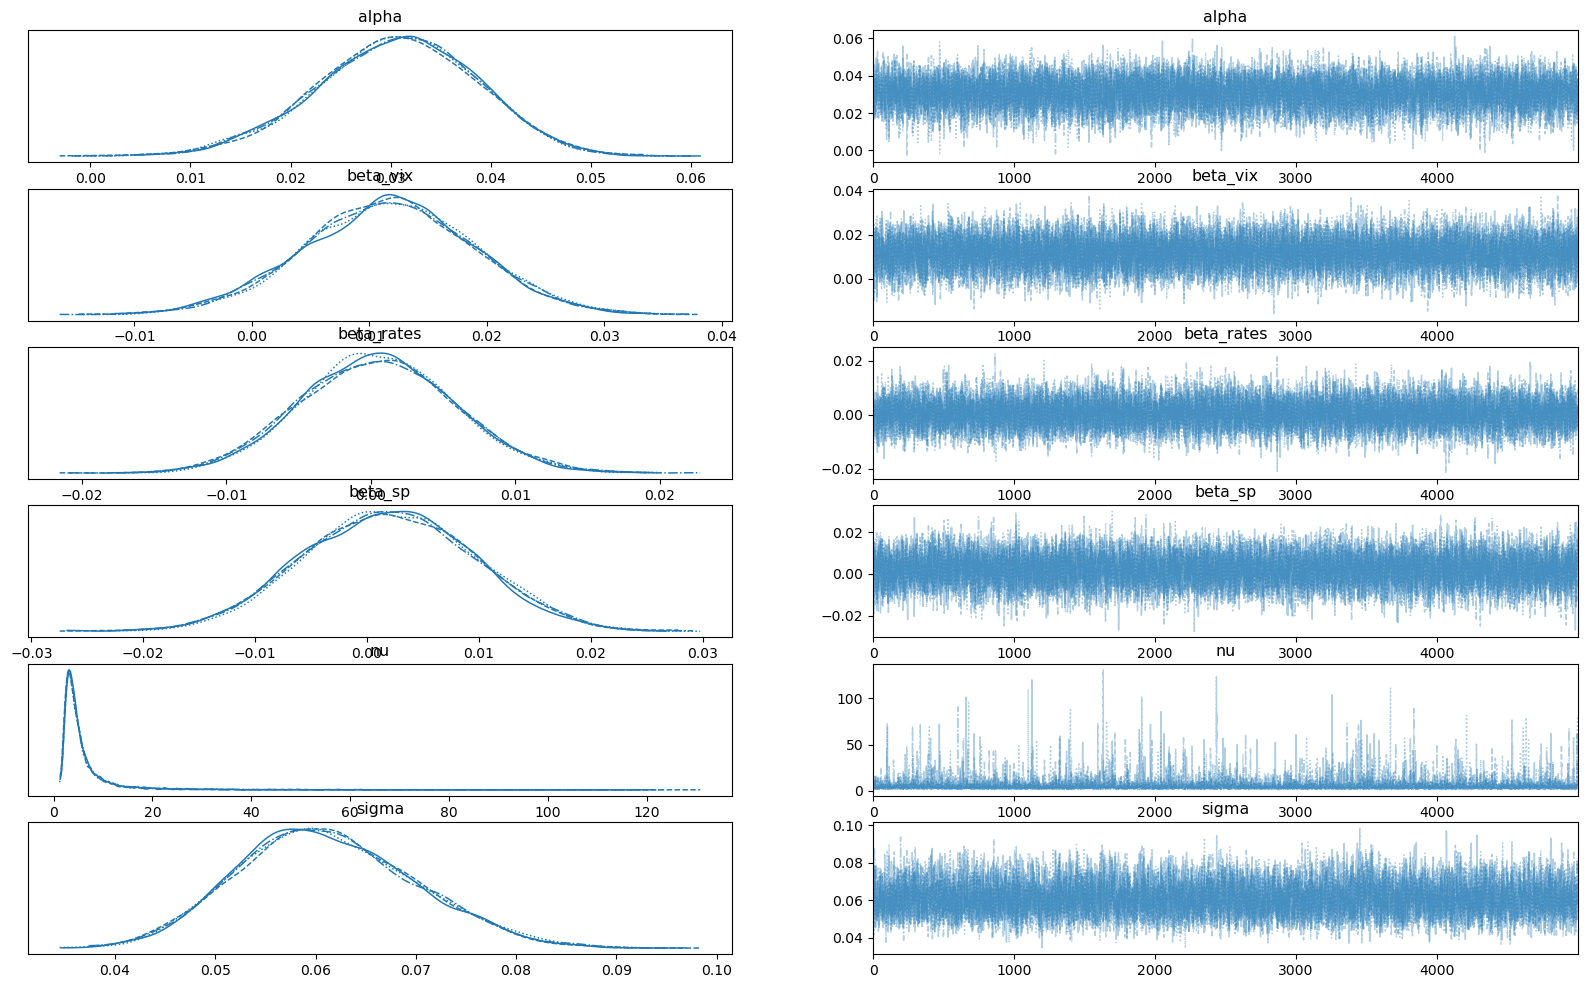

In [985]:
# Plot the trace of the MCMC samples. 
# This plot shows the values sampled for each parameter over the course of the sampling process.
# The goal is to see good mixing and convergence of the samples.
az.plot_trace(trace, figsize=(20, 12)) 

In [986]:
# Summarize the posterior distribution of the model parameters
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.031,0.008,0.016,0.046,0.000,0.000,10286.0,12781.0,1.0
beta_vix,0.012,0.007,-0.002,0.025,0.000,0.000,14836.0,14052.0,1.0
beta_rates,0.000,0.005,-0.010,0.010,0.000,0.000,15153.0,13925.0,1.0
beta_sp,0.002,0.008,-0.012,0.017,0.000,0.000,11554.0,14019.0,1.0
nu,6.090,6.912,1.378,14.594,0.087,0.061,7668.0,7322.0,1.0
sigma,0.061,0.009,0.046,0.078,0.000,0.000,7848.0,11135.0,1.0


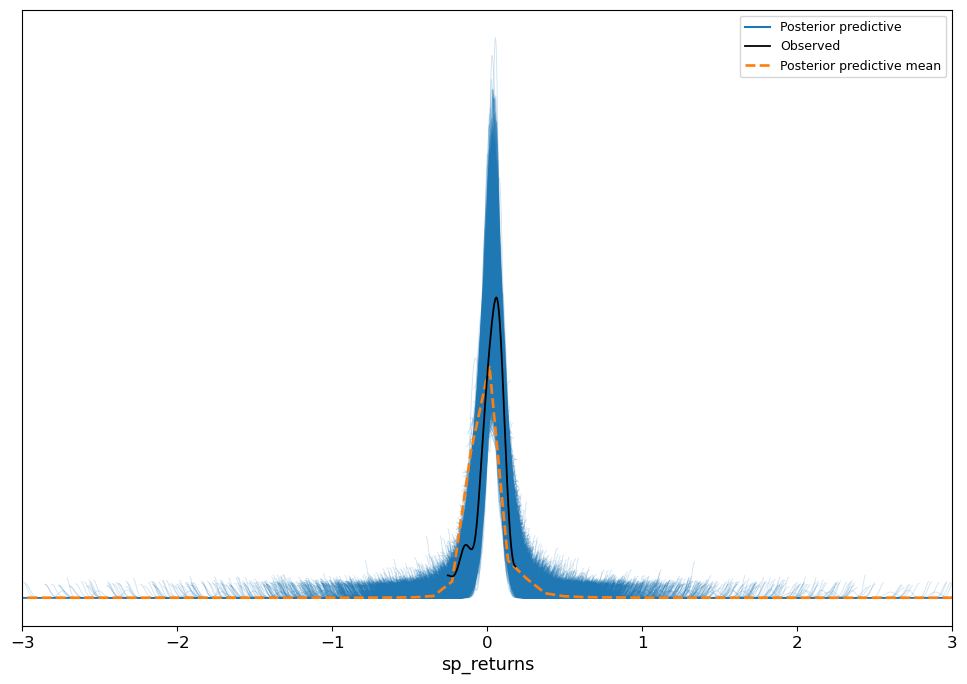

In [987]:
# Plot the posterior predictive distribution of S&P 500 returns
ax = az.plot_ppc(post_pred, group='posterior', data_pairs={'sp_returns': 'sp_returns'},figsize=(12, 8), mean=True, kind='kde', textsize=12)
ax.set_xlim(-3,3)
plt.show()

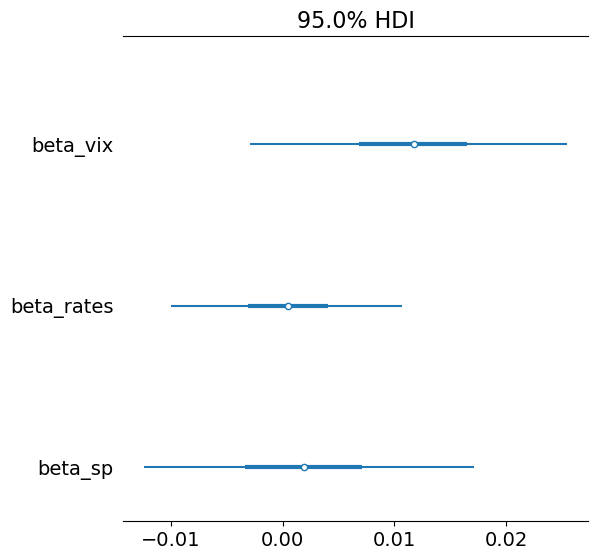

In [988]:
# Plot the posterior distribution of the model parameters
# The plot_forest function provides a visual summary of the posterior distribution of the model parameters
# Values of the model parameters are positive and not inclusive of zero, indicating that they are likely to have an effect on the outcome
az.plot_forest(trace, var_names=['beta_vix', 'beta_rates', 'beta_sp'], combined=True, hdi_prob=0.95)
plt.show()

In [989]:
# Convert the list of predicted probabilities to a DataFrame
predicted_probs_df = pd.DataFrame(predicted_probs, columns=['prob_0_to_5', 'prob_0_to_neg5', 'prob_above_5', 'prob_below_neg5'])

# Reset the index of y_test to match the index of predicted_probs_df
y_test_reset = y_test.reset_index(drop=True)

# Concatenate the predicted probabilities and the actual returns into a single DataFrame
results_df = pd.concat([predicted_probs_df, y_test_reset], axis=1)

# Convert log returns to simple returns
results_df['sp_returns'] = np.exp(results_df['sp_returns']) - 1

# Display the results
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns
0,0.185993,0.158442,0.422393,0.233173,0.070272
1,0.183855,0.155577,0.425127,0.235441,0.082999
2,0.185308,0.156272,0.426617,0.231804,-0.036476
3,0.191605,0.161840,0.419998,0.226557,0.112354
4,0.187089,0.158192,0.424987,0.229733,0.068438


In [990]:
# Reset the index of y_test to get the dates
y_test_reset = y_test.reset_index()

# Rename the 'index' column to 'Date'
y_test_reset = y_test_reset.rename(columns={'index': 'Date'})

# Concatenate the predicted probabilities, the actual returns, and the dates into a single DataFrame
results_df = pd.concat([predicted_probs_df, y_test_reset], axis=1)

# Convert log returns to simple returns
results_df['sp_returns'] = np.exp(results_df['sp_returns']) - 1

# Display the results
results_df = results_df.set_index('Date')  # Set the 'Date' column as the index
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns
Date,,,,,
2023-01-01,0.185993,0.158442,0.422393,0.233173,0.070272
2023-04-01,0.183855,0.155577,0.425127,0.235441,0.082999
2023-07-01,0.185308,0.156272,0.426617,0.231804,-0.036476
2023-10-01,0.191605,0.161840,0.419998,0.226557,0.112354
2024-01-01,0.187089,0.158192,0.424987,0.229733,0.068438


In [992]:
# Define a function to assign the prediction based on the highest probability
def assign_prediction(row):
    # Get the column name of the highest probability
    highest_prob_col = row[['prob_0_to_5', 'prob_0_to_neg5', 'prob_above_5', 'prob_below_neg5']].idxmax()

    # Check if the actual return falls within the range of the highest predicted probability
    if highest_prob_col == 'prob_0_to_5' and 0 <= row['sp_returns'] <= 0.05:
        return 1
    elif highest_prob_col == 'prob_0_to_neg5' and -0.05 <= row['sp_returns'] < 0:
        return 1
    elif highest_prob_col == 'prob_above_5' and row['sp_returns'] > 0.05:
        return 1
    elif highest_prob_col == 'prob_below_neg5' and row['sp_returns'] < -0.05:
        return 1
    else:
        return 0

# Apply the function to each row in the DataFrame
results_df['prediction'] = results_df.apply(assign_prediction, axis=1)
results_df

,prob_0_to_5,prob_0_to_neg5,prob_above_5,prob_below_neg5,sp_returns,prediction
Date,,,,,,
2023-01-01,0.185993,0.158442,0.422393,0.233173,0.070272,1
2023-04-01,0.183855,0.155577,0.425127,0.235441,0.082999,1
2023-07-01,0.185308,0.156272,0.426617,0.231804,-0.036476,0
2023-10-01,0.191605,0.161840,0.419998,0.226557,0.112354,1
2024-01-01,0.187089,0.158192,0.424987,0.229733,0.068438,1
